# ANT

In [16]:
import numpy as np
import networkx as nx
import random
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [17]:
# Fonction d'initialisation des phéromones
def initialize_pheromones(G):
    pheromones = {}
    for edge in G.edges():
        pheromones[edge] = 1.0
        pheromones[(edge[1], edge[0])] = 1.0  # Assurer la symétrie
    return pheromones

In [18]:
# Fonction pour calculer la probabilité de transition
def calculate_transition_probabilities(G, pheromones, alpha, beta, current_node, visited):
    probabilities = {}
    total_sum = 0.0
    for neighbor in G.neighbors(current_node):
        if neighbor not in visited:
            distance = G[current_node][neighbor]['weight']
            probabilities[neighbor] = (pheromones[(current_node, neighbor)] ** alpha) * \
                                      ((1.0 / distance) ** beta)
            total_sum += probabilities[neighbor]
    
    if total_sum == 0:
        return None

    for neighbor in probabilities:
        probabilities[neighbor] /= total_sum
    
    return probabilities

In [19]:
# Fonction pour trouver un chemin pour une fourmi
def find_path(G, pheromones, alpha, beta, start_node):
    path = [start_node]
    visited = set(path)
    current_node = start_node
    while len(visited) < len(G.nodes()):
        probabilities = calculate_transition_probabilities(G, pheromones, alpha, beta, current_node, visited)
        if probabilities is None:
            return None
        next_node = random.choices(list(probabilities.keys()), weights=list(probabilities.values()))[0]
        path.append(next_node)
        visited.add(next_node)
        current_node = next_node
    path.append(start_node)  # Retourner au point de départ
    return path

In [20]:
# Fonction pour mettre à jour les phéromones
def update_pheromones(G, pheromones, paths, decay):
    for edge in pheromones:
        pheromones[edge] *= (1 - decay)
    for path in paths:
        length = calculate_path_length(G, path)
        for i in range(len(path) - 1):
            from_node = path[i]
            to_node = path[i + 1]
            if (from_node, to_node) in pheromones:
                pheromones[(from_node, to_node)] += 1.0 / length
                pheromones[(to_node, from_node)] += 1.0 / length  # Assurer la symétrie

In [21]:
# Fonction pour calculer la longueur d'un chemin
def calculate_path_length(G, path):
    length = 0
    for i in range(len(path) - 1):
        from_node = path[i]
        to_node = path[i + 1]
        if G.has_edge(from_node, to_node):
            length += G[from_node][to_node]['weight']
        else:
            return float('inf')  # Retourner une longueur infinie si l'arête n'existe pas
    return length

In [9]:
# Fonction principale de l'algorithme
def ant_colony_optimization(G, num_ants, num_iterations, decay, alpha, beta, show_progress=True):
    pheromones = initialize_pheromones(G)
    best_path = None
    best_length = float('inf')
    
    # Sélectionnez la méthode d'itération en fonction du paramètre show_progress
    iterations = tqdm(range(num_iterations), desc="Iterations") if show_progress else range(num_iterations)
    
    for iteration in iterations:
        paths = []
        for _ in range(num_ants):
            start_node = random.choice(list(G.nodes()))
            path = find_path(G, pheromones, alpha, beta, start_node)
            if path is None:
                continue
            length = calculate_path_length(G, path)
            if length == float('inf'):
                continue
            paths.append(path)
            if length < best_length:
                best_length = length
                best_path = path
        update_pheromones(G, pheromones, paths, decay)
        # print(f"Iteration {iteration+1}/{num_iterations}, Best length: {best_length}")
    return best_path, best_length

In [10]:
def brute_force(G):
    nodes = list(G.nodes())
    min_path = None
    min_length = float('inf')
    permutations = list(itertools.permutations(nodes))
    for perm in tqdm(permutations, desc="Calcul naïf"):
        current_length = 0
        valid = True
        # Calculer la longueur du chemin pour cette permutation
        for i in range(len(perm) - 1):
            if G.has_edge(perm[i], perm[i + 1]):
                current_length += G[perm[i]][perm[i + 1]]['weight']
            else:
                valid = False
                break
        if valid and G.has_edge(perm[-1], perm[0]):
            current_length += G[perm[-1]][perm[0]]['weight']
        else:
            valid = False
        # Mettre à jour le chemin minimal si un chemin valide plus court est trouvé
        if valid and current_length < min_length:
            min_length = current_length
            min_path = perm
    if min_path is not None:
        min_path = list(min_path)
        min_path.append(min_path[0])  # Retour au point de départ
    return min_path, min_length

In [11]:
# Extrait du notebook Génération & Visualisation des graphes
# Fonction pour générer un graphe aléatoire
def random_graph(num_nodes):
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            weight = random.randint(1, 10)
            G.add_edge(i, j, weight=weight)
    return G

## Code pour la mesure statistique 

In [12]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

def measure_variations(G, fixed_num_ants, list_num_ants, fixed_num_iterations, list_num_iterations, fixed_decay, list_decay, fixed_alpha, list_alpha, fixed_beta, list_beta, show_progress=False):
    def measure_single_param_variation(param_name, param_values, other_params):
        times = []
        distances = []

        for value in tqdm(param_values, desc=f"Measuring {param_name}"):
            params = other_params.copy()
            params[param_name] = value
            start_time = time.time()
            best_path, best_length = ant_colony_optimization(G, **params, show_progress=show_progress)
            end_time = time.time()
            
            execution_time = end_time - start_time
            
            times.append(execution_time)
            distances.append(best_length)
        
        return times, distances
    
    # Mesure des variations pour chaque paramètre
    metrics = {}
    
    metrics['num_ants'] = measure_single_param_variation('num_ants', list_num_ants, {
        'num_ants': fixed_num_ants,
        'num_iterations': fixed_num_iterations,
        'decay': fixed_decay,
        'alpha': fixed_alpha,
        'beta': fixed_beta
    })
    
    metrics['num_iterations'] = measure_single_param_variation('num_iterations', list_num_iterations, {
        'num_ants': fixed_num_ants,
        'num_iterations': fixed_num_iterations,
        'decay': fixed_decay,
        'alpha': fixed_alpha,
        'beta': fixed_beta
    })
    
    metrics['decay'] = measure_single_param_variation('decay', list_decay, {
        'num_ants': fixed_num_ants,
        'num_iterations': fixed_num_iterations,
        'decay': fixed_decay,
        'alpha': fixed_alpha,
        'beta': fixed_beta
    })
    
    metrics['alpha'] = measure_single_param_variation('alpha', list_alpha, {
        'num_ants': fixed_num_ants,
        'num_iterations': fixed_num_iterations,
        'decay': fixed_decay,
        'alpha': fixed_alpha,
        'beta': fixed_beta
    })
    
    metrics['beta'] = measure_single_param_variation('beta', list_beta, {
        'num_ants': fixed_num_ants,
        'num_iterations': fixed_num_iterations,
        'decay': fixed_decay,
        'alpha': fixed_alpha,
        'beta': fixed_beta
    })

    # Tracer les résultats
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    for idx, (param_name, (times, distances)) in enumerate(metrics.items()):
        ax1 = axes[idx]
        param_values = eval(f"list_{param_name}")
        
        ax1.set_xlabel(f'{param_name}')
        ax1.set_ylabel('Temps d\'exécution (s)', color='tab:red')
        ax1.plot(param_values, times, label='Temps d\'exécution', color='tab:red')
        ax1.tick_params(axis='y', labelcolor='tab:red')
        ax1.legend(loc="upper left")
        
        ax1b = ax1.twinx()
        ax1b.set_ylabel('Distance du meilleur chemin', color='tab:blue')
        ax1b.plot(param_values, distances, label='Distance du meilleur chemin', color='tab:blue')
        ax1b.tick_params(axis='y', labelcolor='tab:blue')
        ax1b.legend(loc="upper right")
        
    fig.delaxes(axes[-1])  # Supprimer le dernier axe vide si nécessaire
    fig.tight_layout()
    plt.suptitle('Variations des performances de l\'algorithme de colonie de fourmis', y=1.02)
    plt.show()

Measuring beta: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.19s/it]


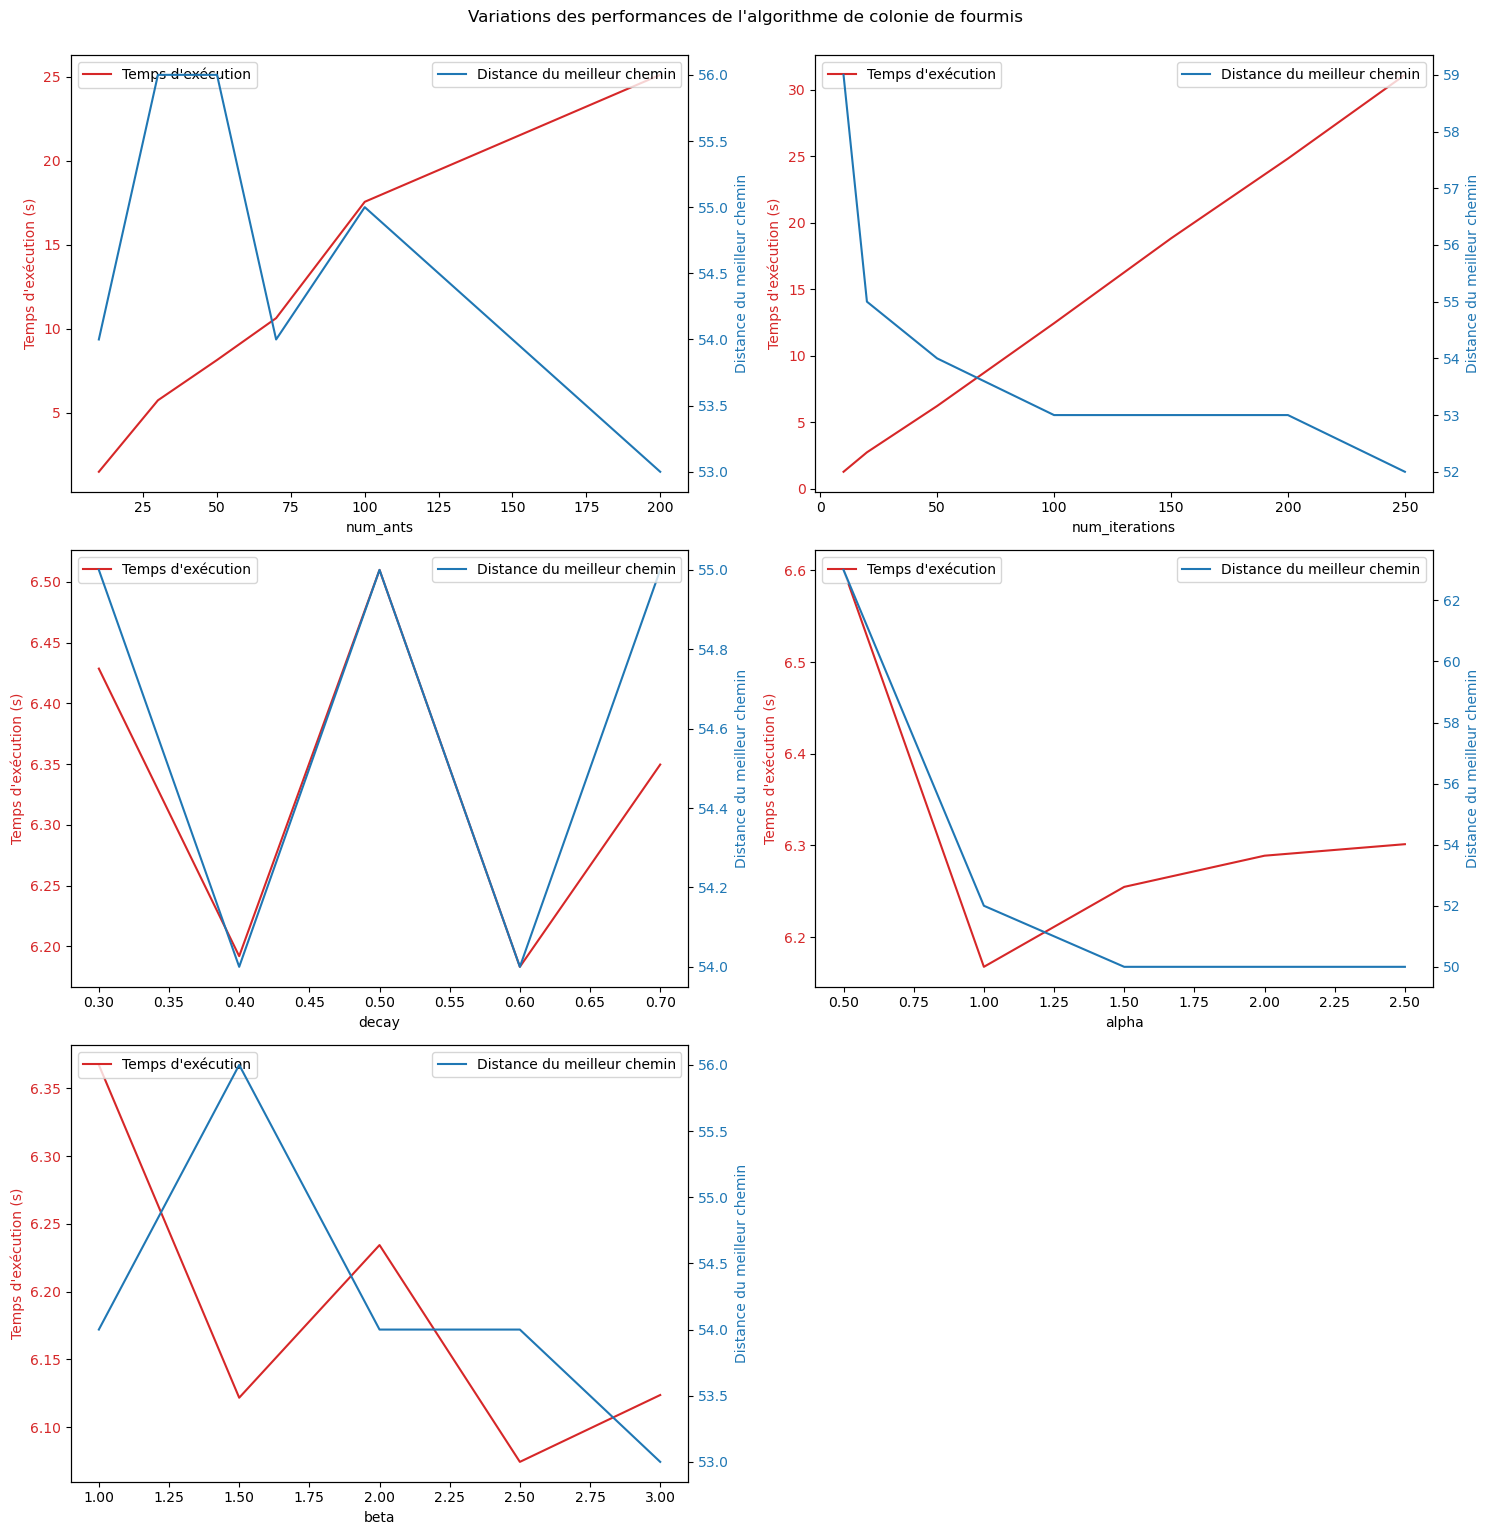

In [15]:
# Exemple d'utilisation
G = random_graph(50)
fixed_num_ants = 50
list_num_ants = [10, 30, 50, 70, 100, 200]
fixed_num_iterations = 50
list_num_iterations = [10, 20, 50, 100, 150, 200, 250]
fixed_decay = 0.5
list_decay = [0.3, 0.4, 0.5, 0.6, 0.7]
fixed_alpha = 1
list_alpha = [0.5, 1, 1.5, 2, 2.5]
fixed_beta = 2
list_beta = [1, 1.5, 2, 2.5, 3]

measure_variations(G, fixed_num_ants, list_num_ants, fixed_num_iterations, list_num_iterations, fixed_decay, list_decay, fixed_alpha, list_alpha, fixed_beta, list_beta, show_progress=False)
